<a href="https://colab.research.google.com/github/gaborvecsei/Stocks-Pattern-Analyzer/blob/master/Time_Series_Matcher_KDTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance &> /dev/null

In [84]:
import numpy as np
import yfinance
import pandas as pd
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def normalize(x, axis=0):
    # If axis=0 then columns are normalized, if it is 1 then rows
    return (x - np.min(x, axis=axis)) / np.ptp(x, axis=axis)

# Preparation

In [176]:
STOCK_TICKERS = ["AAPL", "MSFT", "AMZN", "BABA", "ROKU", "TDOC", "CRSP", "SQ", "NVTA", "Z", "BIDU", "SPOT", "PRLB", "TSLA", "GME"]
WINDOW_SIZE = 14

In [182]:
# Max number of windows = number of years * days in a year * number of tickers
max_values_per_stock = 5 * 365
max_nb_windows = (max_values_per_stock * len(STOCK_TICKERS))

# This holds the original values
ticker_originals = np.zeros((len(STOCK_TICKERS), max_values_per_stock), dtype=np.float16)
# This holds the normalized values of the selected window from a stock
ticker_windows = np.zeros((max_nb_windows, WINDOW_SIZE), dtype=np.float16)
# This holds the start and end indices from a dataframe
ticker_window_indices = np.zeros((max_nb_windows, 2), dtype=np.uint16)
# This holds which ticker the window belongs to (ticker is encoded with it's index in the list)
window_labels = np.zeros(max_nb_windows, dtype=np.uint8)
# As we are pre-allocating arrays, with this we can crop the unnecessary part which does not contain data 
useful_data_mask = np.zeros(max_nb_windows, dtype=bool)
# This dict will hold the label to ticker mapping
ticker_to_label = {}

In [183]:
row = 0

for ticker_label, t in enumerate(STOCK_TICKERS):
    ticker_df = yfinance.Ticker(t).history(period="5y", interval="1d")
    close_values = ticker_df["Close"].values
    
    ticker_originals[ticker_label, :len(close_values)] = close_values
    ticker_to_label[t] = ticker_label
    
    for i in range(0, len(ticker_df)-WINDOW_SIZE, 1):
        start_index = i
        end_index = i + WINDOW_SIZE
        norm_values = normalize(close_values[start_index:end_index])

        ticker_window_indices[row, :] = [start_index, end_index]
        ticker_windows[row, :] = norm_values
        window_labels[row] = ticker_label
        useful_data_mask[row] = 1
        row += 1

In [184]:
ticker_windows = ticker_windows[useful_data_mask]
window_labels = window_labels[useful_data_mask]
ticker_window_indices = ticker_window_indices[useful_data_mask]

In [185]:
label_to_ticker = {v:k for k, v in ticker_to_label.items()}

In [186]:
ticker_windows.shape

(17531, 14)

# KDTree

In [187]:
kdtree = KDTree(ticker_windows)

In [209]:
anchor_ticker = "TSLA"
anchor_windows = ticker_windows[window_labels == ticker_to_label[anchor_ticker]]

In [210]:
anchor_values_norm = anchor_windows[0, :]

In [211]:
top_K_distances, top_K_indices = kdtree.query(anchor_values_norm.reshape(1, -1), k=10)
top_K_indices = top_K_indices.ravel()

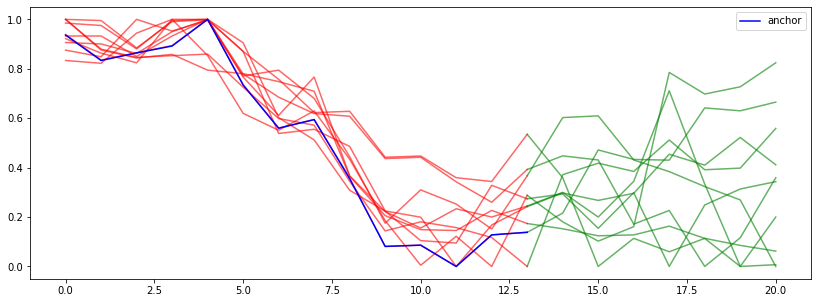

In [212]:
fig, ax0 = plt.subplots(1, 1, figsize=(14, 5))
for i in top_K_indices:
    ticker_label = window_labels[i]
    ticker = label_to_ticker[ticker_label]
    start, end = ticker_window_indices[i]

    vals_norm = normalize(ticker_originals[ticker_label][start:end+7])
    x_vals = np.arange(len(vals_norm))

    ax0.plot(x_vals[:WINDOW_SIZE], vals_norm[:WINDOW_SIZE], color="r", alpha=0.6)
    ax0.plot(x_vals[WINDOW_SIZE-1:], vals_norm[WINDOW_SIZE-1:], color="g", alpha=0.6)

ax0.plot(anchor_values_norm, label="anchor", color="blue")
ax0.legend();